In [46]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import cut_tree
from scipy.cluster.hierarchy import linkage
from scipy.spatial.distance import pdist
from scipy.stats import zscore, ttest_1samp

# import some data to play with
iris = datasets.load_iris()
X = iris.data
y = iris.target

# X = PCA(n_components=3).fit_transform(X)

dist_triu = pdist(X)

Considering 150 classes
Considering 78 classes
Considering 50 classes
Considering 29 classes
Considering 28 classes
Considering 19 classes
p_value is 0.0
Considering 11 classes
p_value is 0.71
Considering 8 classes
p_value is 0.81
Considering 9 classes
p_value is 0.05
Considering 1 classes
Considering 21 classes
Considering 16 classes
p_value is 0.68
Considering 5 classes
p_value is 0.85
Considering 28 classes
Considering 24 classes
Considering 23 classes
Considering 1 classes
Considering 4 classes
p_value is 0.05
Considering 72 classes
Considering 60 classes
Considering 38 classes
Considering 22 classes
Considering 12 classes
p_value is 0.18


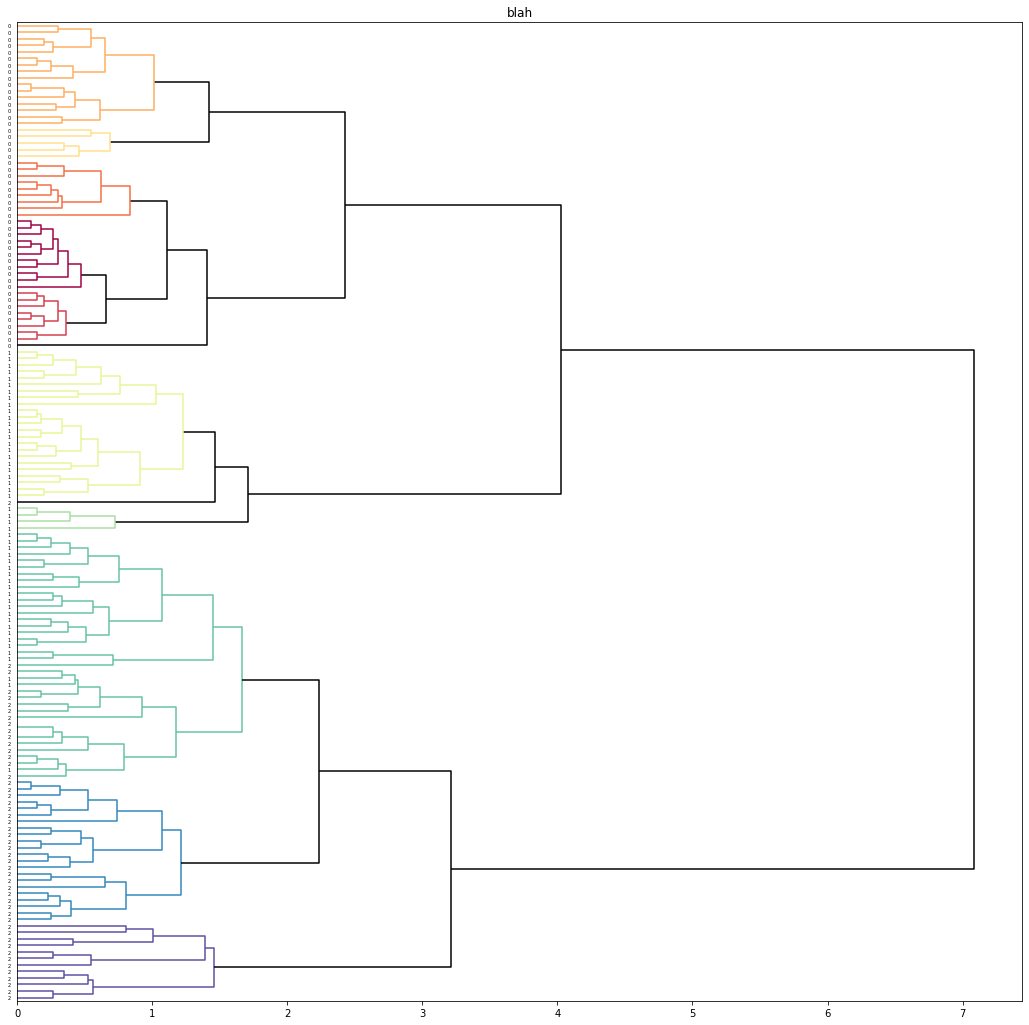

In [47]:
import numpy as np
from koe.management.utils.matplotlib_utils import show_highlighed_cls_syllables, plot_dendrogram
from koe.management.abstract_commands.run_symprof import PcaPermuter

def calc_ranking(class_measures):
    class_dist = pdist(class_measures)
    sorted_dist = np.sort(class_dist)
    return sorted_dist


def is_variance_structural(measures, dist_triu, permuter, significance, ntrials):
    if measures.shape[1] < 3:
        return False

    observed_dist_variance = np.var(dist_triu, axis=0)
    observed_dist_variance_sorted = np.sort(observed_dist_variance)
    simulated_dist_variances_sorted = np.ndarray((ntrials, observed_dist_variance_sorted.shape[0]))

    for i in range(ntrials):
        new_class_measures = permuter.permute(measures)
        class_dist_triu = pdist(new_class_measures)
        simulated_dist_variances_sorted_ = np.var(class_dist_triu, axis=0)

    t_value, p_value = ttest_1samp(dist_variances, observed_dist_variance)

    # # mean_random_deviations is an array of ntrials elements
    # mean_random_deviations = np.sum(random_deviations, axis=1)
    #
    # observed_deviation = np.sum(np.abs(original_rankings - trial_mean))
    #
    # # Tree is structural if the real rankings are different from a random draw from permuted rankings
    # # that is, if there are less than x% (e.g. 5%) of random deviations larger than the observed deviation

    # p_value = np.sum(mean_random_deviations > observed_deviation) / ntrials
    # if measures.shape[0] <= 20:
#     print('p_value = {}, t_value={}'.format(p_value, t_value))
    return p_value < significance


def are_rankings_structural(measures, dist_triu, permuter, significance, ntrials):
    if len(dist_triu) < 3:
        return False
    original_rankings = np.sort(dist_triu)
    rankings = np.ndarray((ntrials, original_rankings.shape[0]))
    for i in range(ntrials):
        new_class_measures = permuter.permute(measures)
        rankings[i, :] = calc_ranking(new_class_measures)

    # Trial_mean is an array of len(dist_triu) elements, so is trial_std and random_deviations
    trial_mean = np.mean(rankings, axis=0)
    random_deviations = np.abs(rankings - trial_mean)

    # mean_random_deviations is an array of ntrials elements
    mean_random_deviations = np.sum(random_deviations, axis=1)

    observed_deviation = np.sum(np.abs(original_rankings - trial_mean))

    # Tree is structural if the real rankings are different from a random draw from permuted rankings
    # that is, if there are less than x% (e.g. 5%) of random deviations larger than the observed deviation

    p_value = np.sum(mean_random_deviations > observed_deviation) / ntrials
    if measures.shape[0] <= 20:
        print('p_value is {}'.format(p_value))
    return p_value < significance



def cut_tree_get_leaves(tree, height):
    cluster = cut_tree(tree, height=height)
    leaves = []
    nleaves = cluster.max() + 1
    for i in range(nleaves):
        leaf_class_inds = np.where(cluster == i)[0]
        leaves.append(leaf_class_inds)
    return leaves



def recursive_simprof(global_measures, permuter, global_cls_inds, clusters, min_cluster_size=3, max_deviation=0.05,
                      ntrials=100, is_structural=is_variance_structural):
    print('Considering {} classes'.format(len(global_cls_inds)))
    if global_cls_inds.shape[0] < min_cluster_size:
        clusters.append(global_cls_inds)
        return

    local_measures = global_measures[global_cls_inds, :]
    local_to_global_inds = {l: g for l, g in enumerate(global_cls_inds)}

    dist_triu = pdist(local_measures)
    local_tree = linkage(dist_triu, method='complete')
    cutoff = local_tree[:, 2].max()

    if is_structural(local_measures, dist_triu, permuter, max_deviation, ntrials):
        leaves = cut_tree_get_leaves(local_tree, cutoff)
        for leaf_class_inds in leaves:
            leaf_class_global_inds = np.array([local_to_global_inds[i] for i in leaf_class_inds])
            recursive_simprof(global_measures, permuter, leaf_class_global_inds, clusters, min_cluster_size,
                              max_deviation, ntrials, is_structural)
    else:
        clusters.append(global_cls_inds)


tree = linkage(dist_triu, method='complete')

inital_inds = np.arange(len(y))
clusters = []
nclasses, nfeatures = X.shape
permuter = PcaPermuter(nfeatures)
recursive_simprof(X, permuter, inital_inds, clusters, max_deviation=0.05, is_structural=is_variance_structural)

plot_dendrogram(tree, 'blah', label_arr=y, clusters=clusters)

In [37]:
iris.data.shape

(150, 4)